<a href="https://colab.research.google.com/github/ad-batrisyia/money-laundering-detection-ml/blob/main/notebooks/07_Final_Evaluation_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path where you saved it
load_path = '/content/drive/MyDrive/Money Laundering Detection/PreprocessedData.csv'

# Load the CSV
df = pd.read_csv(load_path)

df.head()

,Amount,Payment_type,Is_laundering,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Laundering_Structure
0,1459.15,1,0,0,0,1,0.0,1857.866667,304,2
1,6019.64,5,0,0,0,102,0.0,5889.320323,303,6
2,14328.44,3,0,0,0,3,0.0,10167.677647,304,6
3,11895.00,0,0,0,0,9,0.0,11937.773333,304,5
4,115.25,1,0,0,0,1,0.0,1068.905000,304,2


In [ ]:
df.shape

(9504852, 10)

In [ ]:
#Add transaction_id based on row index
df['Transaction_ID'] = range(1, len(df) + 1)

In [ ]:
df.head(5)

,Amount,Payment_type,Is_laundering,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Laundering_Structure,Transaction_ID
0,1459.15,1,0,0,0,1,0.0,1857.866667,304,2,1
1,6019.64,5,0,0,0,102,0.0,5889.320323,303,6,2
2,14328.44,3,0,0,0,3,0.0,10167.677647,304,6,3
3,11895.00,0,0,0,0,9,0.0,11937.773333,304,5,4
4,115.25,1,0,0,0,1,0.0,1068.905000,304,2,5


In [ ]:
X = df.drop(columns=['Is_laundering'], axis=1)
y = df['Is_laundering']

In [ ]:
# Keep Transaction_ID separately
transaction_ids = X['Transaction_ID']

# Drop it from features
X = X.drop(columns=['Transaction_ID'])

## Split Train-Validation-Test 70:15:15

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
import numpy as np

# ====================
# 2) Train-Validate-Test Split
# ====================
# First split off test set (15%)
x_trainval, x_test, y_trainval, y_test, id_train_val, id_test = train_test_split(
    X, y, transaction_ids, test_size=0.15, stratify=y, random_state=42
)

# Then split trainval into train (70%) + validation (15%)
x_train, x_val, y_train, y_val, id_train, id_val = train_test_split(
    x_trainval, y_trainval, id_train_val, test_size=0.176, stratify=y_trainval, random_state=42
)
# (0.176 of 0.85 = 0.15 total)

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (6657198, 9) y_train: (6657198,)
x_val: (1421926, 9) y_val: (1421926,)
x_test: (1425728, 9) y_test: (1425728,)


In [ ]:
# Class distribution in training set
print("\nClass distribution in y_train:")
print(y_train.value_counts())

# Class distribution in validation set
print("\nClass distribution in y_train:")
print(y_val.value_counts())

# Class distribution in testing set
print("\nClass distribution in y_test:")
print(y_test.value_counts())


Class distribution in y_train:
Is_laundering
0    6650283
1       6915
Name: count, dtype: int64

Class distribution in y_train:
Is_laundering
0    1420449
1       1477
Name: count, dtype: int64

Class distribution in y_test:
Is_laundering
0    1424247
1       1481
Name: count, dtype: int64


## Train Model

### Baseline Model Result

In [ ]:
# ====================
# Utility function for evaluation
# ====================
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# === Random Forest Baseline ===
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
y_val_pred_rf = rf.predict(x_val)

# === XGBoost Baseline ===
xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1)

xgb.fit(x_train, y_train)
y_val_pred_xgb = xgb.predict(x_val)

evaluate_model("Random Forest", y_val, y_val_pred_rf)
evaluate_model("XGBoost", y_val, y_val_pred_xgb)


=== Random Forest ===
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998   1420449
           1     0.9894    0.6919    0.8143      1477

    accuracy                         0.9997   1421926
   macro avg     0.9945    0.8460    0.9071   1421926
weighted avg     0.9997    0.9997    0.9996   1421926

Confusion Matrix:
[[1420438      11]
 [    455    1022]]

=== XGBoost ===
Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998   1420449
           1     0.8923    0.6845    0.7747      1477

    accuracy                         0.9996   1421926
   macro avg     0.9460    0.8422    0.8873   1421926
weighted avg     0.9996    0.9996    0.9996   1421926

Confusion Matrix:
[[1420327     122]
 [    466    1011]]


### Hyperparameter Tuning

In [ ]:
# ====================
# Subsample for tuning
# ====================
x_train_sub, _, y_train_sub, _ = train_test_split(
    x_train, y_train, train_size=200000, stratify=y_train, random_state=42
)
print(f"Tuning on subsample: {x_train_sub.shape}")

# ====================
# 4) Random Forest Hyperparameter Tuning
# ====================
rf_param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_dist,
    n_iter=5, cv=3, scoring="f1", n_jobs=-1, random_state=42
)
rf_search.fit(x_train_sub, y_train_sub)
best_rf = rf_search.best_estimator_
print("\nBest RF Params:", rf_search.best_params_)

# Refit on full training data
best_rf.fit(x_train, y_train)
y_val_pred_rf = best_rf.predict(x_val)
evaluate_model("Random Forest (Tuned)", y_val, y_val_pred_rf)


# ====================
# 5) XGBoost Hyperparameter Tuning
# ====================
xgb_param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}
xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric="logloss", n_jobs=-1),
    xgb_param_dist,
    n_iter=5, cv=3, scoring="f1", n_jobs=-1, random_state=42
)
xgb_search.fit(x_train_sub, y_train_sub)
best_xgb = xgb_search.best_estimator_
print("\nBest XGB Params:", xgb_search.best_params_)

# Refit on full training data
best_xgb.fit(x_train, y_train)
y_val_pred_xgb = best_xgb.predict(x_val)
evaluate_model("XGBoost (Tuned)", y_val, y_val_pred_xgb)

Tuning on subsample: (200000, 9)

Best RF Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}

=== Random Forest (Tuned) ===
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998   1420449
           1     0.9894    0.6919    0.8143      1477

    accuracy                         0.9997   1421926
   macro avg     0.9945    0.8460    0.9071   1421926
weighted avg     0.9997    0.9997    0.9996   1421926

Confusion Matrix:
[[1420438      11]
 [    455    1022]]

Best XGB Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}

=== XGBoost (Tuned) ===
Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998   1420449
           1     0.9614    0.6750    0.7932      1477

    accuracy                         0.9996   1421926
   macro avg     0.9805    0.8375    0.8965   14219

### Adjust Threshold

In [ ]:
from sklearn.metrics import f1_score

def tune_threshold(model, X_val, y_val, name):
    """Find best threshold on validation set for max F1"""
    probs = model.predict_proba(X_val)[:, 1]
    best_thresh, best_f1 = 0.5, 0
    for thresh in np.linspace(0.1, 0.9, 41):  # fewer steps for speed
        preds = (probs >= thresh).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh
    print(f"{name} best threshold: {best_thresh:.2f}, best F1: {best_f1:.4f}")
    return best_thresh

# ====================
# 4) Random Forest
# ====================
rf_thresh = tune_threshold(best_rf, x_val, y_val, "Random Forest")
y_val_pred_rf = (best_rf.predict_proba(x_val)[:, 1] >= rf_thresh).astype(int)
evaluate_model("Random Forest (Validation)", y_val, y_val_pred_rf)

# ====================
# 5) XGBoost
# ====================
xgb_thresh = tune_threshold(best_xgb, x_val, y_val, "XGBoost")
y_val_pred_xgb = (best_xgb.predict_proba(x_val)[:, 1] >= xgb_thresh).astype(int)
evaluate_model("XGBoost (Validation)", y_val, y_val_pred_xgb)


Random Forest best threshold: 0.24, best F1: 0.8336

=== Random Forest (Validation) ===
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998   1420449
           1     0.9185    0.7630    0.8336      1477

    accuracy                         0.9997   1421926
   macro avg     0.9591    0.8815    0.9167   1421926
weighted avg     0.9997    0.9997    0.9997   1421926

Confusion Matrix:
[[1420349     100]
 [    350    1127]]
XGBoost best threshold: 0.28, best F1: 0.7991

=== XGBoost (Validation) ===
Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998   1420449
           1     0.9236    0.7041    0.7991      1477

    accuracy                         0.9996   1421926
   macro avg     0.9617    0.8520    0.8994   1421926
weighted avg     0.9996    0.9996    0.9996   1421926

Confusion Matrix:
[[1420363      86]
 [    43

## Model Evaluation

### Evaluation on Training Set with Best Threshold

In [ ]:
#Evaluation on Training
best_rf.fit(x_train, y_train)
y_train_pred_rf = (best_rf.predict_proba(x_train)[:, 1] >= rf_thresh).astype(int)
evaluate_model("Random Forest (Training)", y_train, y_train_pred_rf)

best_xgb.fit(x_train, y_train)
y_train_pred_xgb = (best_xgb.predict_proba(x_train)[:, 1] >= xgb_thresh).astype(int)
evaluate_model("XGBoost (Training)", y_train, y_train_pred_xgb)


=== Random Forest (Training) ===
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   6650283
           1     0.9978    1.0000    0.9989      6915

    accuracy                         1.0000   6657198
   macro avg     0.9989    1.0000    0.9995   6657198
weighted avg     1.0000    1.0000    1.0000   6657198

Confusion Matrix:
[[6650268      15]
 [      0    6915]]

=== XGBoost (Training) ===
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998   6650283
           1     0.9340    0.7138    0.8092      6915

    accuracy                         0.9997   6657198
   macro avg     0.9668    0.8569    0.9045   6657198
weighted avg     0.9996    0.9997    0.9996   6657198

Confusion Matrix:
[[6649934     349]
 [   1979    4936]]


### Retrain on Train+Validation Set with Best Threshold

In [ ]:
# ====================
# Final Test Evaluation (Train on Train+Val)
# ====================
best_rf.fit(x_trainval, y_trainval)
y_test_pred_rf = (best_rf.predict_proba(x_test)[:, 1] >= rf_thresh).astype(int)
evaluate_model("Random Forest (Final Test)", y_test, y_test_pred_rf)

best_xgb.fit(x_trainval, y_trainval)
y_test_pred_xgb = (best_xgb.predict_proba(x_test)[:, 1] >= xgb_thresh).astype(int)
evaluate_model("XGBoost (Final Test)", y_test, y_test_pred_xgb)




=== Random Forest (Final Test) ===
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998   1424247
           1     0.9113    0.7698    0.8346      1481

    accuracy                         0.9997   1425728
   macro avg     0.9555    0.8848    0.9172   1425728
weighted avg     0.9997    0.9997    0.9997   1425728

Confusion Matrix:
[[1424136     111]
 [    341    1140]]

=== XGBoost (Final Test) ===
Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998   1424247
           1     0.9261    0.6935    0.7931      1481

    accuracy                         0.9996   1425728
   macro avg     0.9629    0.8467    0.8964   1425728
weighted avg     0.9996    0.9996    0.9996   1425728

Confusion Matrix:
[[1424165      82]
 [    454    1027]]


## SAVE PREDICTIONS ON TEST SET

In [ ]:
# ==============================
# Save predictions on test set
# ==============================
# Random Forest
y_test_probs_rf = best_rf.predict_proba(x_test)[:, 1]

df_rf_results = pd.DataFrame({
    "Transaction_ID": id_test,
    "true_label": y_test,
    "predicted_label": y_test_pred_rf,
    "predicted_prob": y_test_probs_rf
})
df_rf_results.to_csv("/content/drive/MyDrive/Money Laundering Detection/rf_test_predictions.csv", index=False)

# XGBoost
y_test_probs_xgb = best_xgb.predict_proba(x_test)[:, 1]

df_xgb_results = pd.DataFrame({
    "Transaction_ID": id_test,
    "true_label": y_test,
    "predicted_label": y_test_pred_xgb,
    "predicted_prob": y_test_probs_xgb
})
df_xgb_results.to_csv("/content/drive/MyDrive/Money Laundering Detection/xgb_test_predictions.csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ==============================
# Function to evaluate & return metrics
# ==============================
def get_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob)
    }

# ==============================
# Save predictions + metrics
# ==============================

results_summary = []

# --- Random Forest ---
metrics_rf = get_metrics(y_test, y_test_pred_rf, y_test_probs_rf)

metrics_rf["Model"] = "Random Forest"
results_summary.append(metrics_rf)

# --- XGBoost ---
metrics_xgb = get_metrics(y_test, y_test_pred_xgb, y_test_probs_xgb)

metrics_xgb["Model"] = "XGBoost"
results_summary.append(metrics_xgb)

# ==============================
# Save metrics for both models
# ==============================
df_metrics = pd.DataFrame(results_summary)
df_metrics.to_csv("/content/drive/MyDrive/Money Laundering Detection/model_metrics.csv", index=False)

print("Metrics saved successfully!")


In [ ]:
# --- Random Forest ---
rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "RF_Importance": best_rf.feature_importances_
})

# --- XGBoost ---
xgb_importances = pd.DataFrame({
    "Feature": X.columns,
    "XGB_Importance": best_xgb.feature_importances_
})

# --- Merge for comparison ---
feature_importance_comparison = rf_importances.merge(
    xgb_importances, on="Feature"
)

# Sort by RF importance (or average of both)
feature_importance_comparison["Avg_Importance"] = (
    feature_importance_comparison[["RF_Importance", "XGB_Importance"]].mean(axis=1)
)
feature_importance_comparison = feature_importance_comparison.sort_values(
    by="Avg_Importance", ascending=False
)

# Save for Power BI
feature_importance_comparison.to_csv(
    "/content/drive/MyDrive/Money Laundering Detection/FeatureImportance_RF_XGB.csv",
    index=False
)

print("✅ RF & XGB feature importance saved for Power BI!")


## AUPRC & AUROC

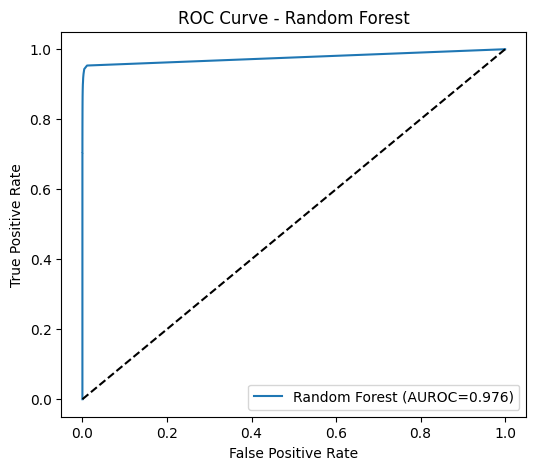

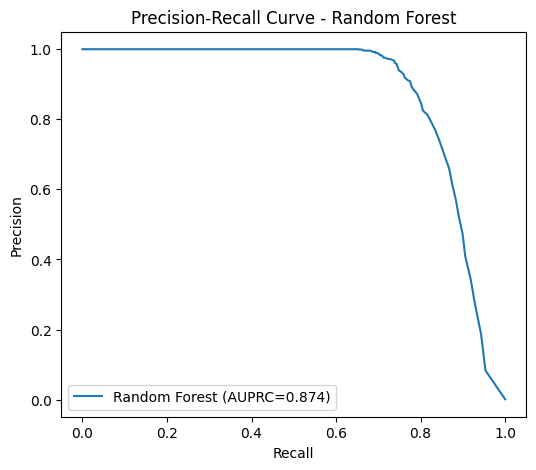

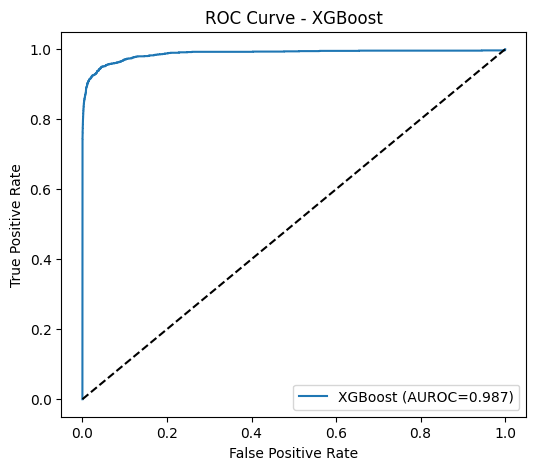

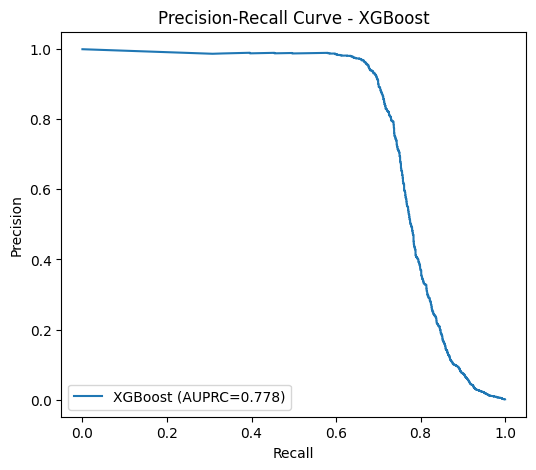

Saved: model_auc_summary.csv, model_roc_points.csv, model_prc_points.csv
           Model     AUROC     AUPRC
0  Random Forest  0.976225  0.874329
1        XGBoost  0.987277  0.777543


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# ==========================
# 1. Evaluate Models
# ==========================

def evaluate_model_auc_prc(model, X_test, y_test, model_name="Model"):
    """
    Compute AUROC, AUPRC, curves and return results for Power BI.
    """
    # Get predicted probabilities (for class 1)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test)

    # AUROC
    auroc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # AUPRC
    auprc = average_precision_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # Plot ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUROC={auroc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    # Plot PRC
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"{model_name} (AUPRC={auprc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()

    # Prepare Power BI export (summary + curve points)
    summary = pd.DataFrame([{
        "Model": model_name,
        "AUROC": auroc,
        "AUPRC": auprc
    }])

    roc_points = pd.DataFrame({"FPR": fpr, "TPR": tpr})
    roc_points["Model"] = model_name

    prc_points = pd.DataFrame({"Recall": recall, "Precision": precision})
    prc_points["Model"] = model_name

    return summary, roc_points, prc_points


# ==========================
# 2. Run for RF and XGB
# ==========================

rf_summary, rf_roc, rf_prc = evaluate_model_auc_prc(best_rf, x_test, y_test, "Random Forest")
xgb_summary, xgb_roc, xgb_prc = evaluate_model_auc_prc(best_xgb, x_test, y_test, "XGBoost")

# Combine results
summary_all = pd.concat([rf_summary, xgb_summary], ignore_index=True)
roc_all = pd.concat([rf_roc, xgb_roc], ignore_index=True)
prc_all = pd.concat([rf_prc, xgb_prc], ignore_index=True)




In [ ]:
summary_all

,Model,AUROC,AUPRC
0,Random Forest,0.976225,0.874329
1,XGBoost,0.987277,0.777543


In [ ]:
roc_all

,FPR,TPR,Model
0,0.000000,0.000000,Random Forest
1,0.000000,0.280891,Random Forest
2,0.000000,0.332208,Random Forest
3,0.000000,0.361918,Random Forest
4,0.000000,0.395003,Random Forest
...,...,...,...
176290,0.999883,0.999325,XGBoost
176291,0.999886,0.999325,XGBoost
176292,0.999921,0.999325,XGBoost
176293,0.999921,1.000000,XGBoost


In [ ]:
prc_all

,Recall,Precision,Model
0,1.000000,0.001039,Random Forest
1,0.953410,0.083166,Random Forest
2,0.943282,0.185303,Random Forest
3,0.929102,0.269592,Random Forest
4,0.918298,0.344391,Random Forest
...,...,...,...
294981,0.328157,0.987805,XGBoost
294982,0.322080,0.987578,XGBoost
294983,0.317353,0.987395,XGBoost
294984,0.307900,0.987013,XGBoost


In [ ]:
# ==========================
# 3. Save to CSV for Power BI
# ==========================

summary_all.to_csv("/content/drive/MyDrive/Money Laundering Detection/model_auc_summary.csv", index=False)
roc_all.to_csv("/content/drive/MyDrive/Money Laundering Detection/model_roc_points.csv", index=False)
prc_all.to_csv("/content/drive/MyDrive/Money Laundering Detection/model_prc_points.csv", index=False)

print("Saved: model_auc_summary.csv, model_roc_points.csv, model_prc_points.csv")
print(summary_all)

Saved: model_auc_summary.csv, model_roc_points.csv, model_prc_points.csv
           Model     AUROC     AUPRC
0  Random Forest  0.976225  0.874329
1        XGBoost  0.987277  0.777543
